# Preamble

In [ ]:
# data processing, EDA, and visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import os

# sklearn libraries, preprocessing steps, and ML models
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# hyperparameter tuning nnd model evaluation
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Importing the Data

In [ ]:
data_dir = "C://Users//gtapa//Desktop//SDSU//Fall 2025//BDA 602//Final Project//Data//dataverse_files" # this is my own filepath, replace this with your own
os.chdir(data_dir)
os.getcwd()

'C:\\Users\\gtapa\\Desktop\\SDSU\\Fall 2025\\BDA 602\\Final Project\\Data\\dataverse_files'

In [ ]:
# this file gives the names and type (oral or gut) of each MSP, along with the MSP code
ref_table_file = "MSP_set_ref_oss_gss_status_612_ref_paper_20250220_gtdb_220.tsv"

# this file is the raw data we will be using, this will be merged with other columns to provide more information
signal_count_file = "species_signal_count_table_2340_CRC_cohort_20240322.tsv"

# this is the metadata file containing the labels for each stool sample (patient) that will be used for supervised training
# also note that this is originally an Excel file, but was converted into a CSV
metadata_file = "metadata_2340_CRC_cohort_20240704//metadata_2340_CRC_cohort_20240704.csv"

In [ ]:
ref_table = pd.read_csv(ref_table_file, sep = "\t")
signal_count = pd.read_csv(signal_count_file, sep = "\t")
signal_count = signal_count.T                                                   # the original file has the MSPs on the rows and the samples on the columns, the transpose makes it easier to understand
metadata = pd.read_csv(metadata_file)

In [ ]:
ref_table.head()

,msp_name_corrected,itol,ref_MSP,msp_id,catalogue,size,completeness,cultured,oxygen,opp_path,MSP_class,gtdb_r220_classification,superkingdom,phylum,class,order,family,genus,species,msp
0,msp_0001_hs,y,gut,msp_0001,gut,14947,NaN,True,0.0,NaN,gss,d__Eukaryota;p__Heterokonta;c__Blastocystae;o_...,Eukaryota,Heterokonta,Blastocystae,Blastocystida,Blastocystidae,Blastocystis,Blastocystis sp. subtype 3,msp_0001
1,msp_0002_hs,y,gut,msp_0002,gut,11854,NaN,True,0.0,NaN,gut,d__Eukaryota;p__Heterokonta;c__Blastocystae;o_...,Eukaryota,Heterokonta,Blastocystae,Blastocystida,Blastocystidae,Blastocystis,Blastocystis sp. subtype 1,msp_0002
2,msp_0003_hs,y,gut,msp_0003,gut,14853,100.00,True,0.0,NaN,gss,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus,msp_0003
3,msp_0004_hs,y,gut,msp_0004,gut,11112,NaN,True,0.0,NaN,gut,d__Eukaryota;p__Heterokonta;c__Blastocystae;o_...,Eukaryota,Heterokonta,Blastocystae,Blastocystida,Blastocystidae,Blastocystis,Blastocystis sp. subtype 2,msp_0004
4,msp_0005_hs,y,gut,msp_0005,gut & oral,12508,95.92,True,1.0,1.0,gss,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,msp_0005


In [ ]:
ref_table['ref_MSP'].unique()

array(['gut', 'oral'], dtype=object)

In [ ]:
signal_count.columns = signal_count.iloc[0]
signal_count = signal_count.drop(signal_count.index[0])                         # this is to promote the top row to the column headers, makes later merging less frustrating
signal_count.head()

msp_id,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_2943,msp_2944,msp_2945,msp_2946,msp_2947,msp_2948,msp_2949,msp_2950,msp_2951,msp_2957
DRS091055,0,0,0,0,116,0,3236,0,745,282,...,0,0,0,0,0,0,0,0,0,0
DRS091039,0,0,0,0,806,0,13354,0,856,18853,...,0,36,0,0,0,0,0,0,0,0
DRS090886,0,0,0,0,16,0,14797,0,1274,0,...,0,0,0,0,0,0,0,0,0,0
DRS090835,0,0,465,0,2292,0,10,0,189,418,...,65,0,0,0,0,0,0,0,0,0
DRS090910,0,0,709,0,0,0,2535,0,406,0,...,0,24,0,0,0,0,0,0,0,0


In [ ]:
metadata = metadata.set_index("sample")
metadata.head()

,HQ_clean_read_count,gut_mapped_read_count,gut_mapped_pc,oral_mapped_read_count,oral_mapped_pc,MGS,low_read,low_map,excluded,excluded_comment,...,body_site,body_subsite,health_status,host_phenotype,host_subphenotype,gender,age,bmi,class,to_exclude
sample,,,,,,,,,,,,,,,,,,,,,
SRS17441337,47916688,36915908,77.041861,7031971,14.675411,311,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,female,71.0,27.343750,CRC,NaN
SRS17441336,60552974,49696859,82.071706,2905675,4.798567,411,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,male,58.0,27.681661,CRC,NaN
SRS17441335,48171808,41489574,86.128330,3307205,6.865437,188,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,female,74.0,24.524346,CRC,NaN
SRS17441334,37323584,29266453,78.412762,1714205,4.592820,260,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,female,76.0,18.611496,CRC,NaN
SRS17441333,33594648,25139320,74.831324,1777330,5.290515,227,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,male,76.0,31.708284,CRC,NaN


# Data Preprocessing

## Generating a Metadata Report

In [ ]:
def create_metadata(df):
  meta_report = pd.DataFrame(index=df.columns)
  meta_report['dtype'] = df.dtypes
  meta_report['n_unique'] = df.nunique()
  meta_report['n_missing'] = df.isnull().sum()
  meta_report['pct_missing'] = meta_report['n_missing'] / df.shape[0]
  meta_report['n_duplicates'] = df.duplicated().sum()
  meta_report['pct_duplicates'] = meta_report['n_duplicates'] / df.shape[0]
  meta_report['is_numeric'] = meta_report['dtype'].apply(
      lambda x: pd.api.types.is_numeric_dtype(x)
  )
  meta_report['is_categorical'] = meta_report['dtype'].apply(
      lambda x: isinstance(x, pd.CategoricalDtype) or x == object
  )
  meta_report['sample_values'] = df.apply(lambda col: col.dropna().unique()[:5])
  return meta_report

In [ ]:
create_metadata(signal_count)

,dtype,n_unique,n_missing,pct_missing,n_duplicates,pct_duplicates,is_numeric,is_categorical,sample_values
msp_id,,,,,,,,,
msp_0001,object,91,0,0.0,0,0.0,False,True,"[0, 2002, 29, 871, 911]"
msp_0002,object,55,0,0.0,0,0.0,False,True,"[0, 3683, 224, 202, 2825]"
msp_0003,object,950,0,0.0,0,0.0,False,True,"[0, 465, 709, 4, 2061]"
msp_0004,object,27,0,0.0,0,0.0,False,True,"[0, 855, 7451, 360, 760]"
msp_0005,object,1541,0,0.0,0,0.0,False,True,"[116, 806, 16, 2292, 0]"
...,...,...,...,...,...,...,...,...,...
msp_2948,object,2,0,0.0,0,0.0,False,True,"[0, 7]"
msp_2949,object,45,0,0.0,0,0.0,False,True,"[0, 46, 19, 28, 15]"
msp_2950,object,58,0,0.0,0,0.0,False,True,"[0, 16, 29, 74, 79]"


## Coercing Features to Integer Types

In [ ]:
for col in signal_count.columns:
  signal_count[col] = pd.to_numeric(signal_count[col], errors='coerce')

In [ ]:
create_metadata(signal_count)

,dtype,n_unique,n_missing,pct_missing,n_duplicates,pct_duplicates,is_numeric,is_categorical,sample_values
msp_id,,,,,,,,,
msp_0001,int64,91,0,0.0,0,0.0,True,False,"[0, 2002, 29, 871, 911]"
msp_0002,int64,55,0,0.0,0,0.0,True,False,"[0, 3683, 224, 202, 2825]"
msp_0003,int64,950,0,0.0,0,0.0,True,False,"[0, 465, 709, 4, 2061]"
msp_0004,int64,27,0,0.0,0,0.0,True,False,"[0, 855, 7451, 360, 760]"
msp_0005,int64,1541,0,0.0,0,0.0,True,False,"[116, 806, 16, 2292, 0]"
...,...,...,...,...,...,...,...,...,...
msp_2948,int64,2,0,0.0,0,0.0,True,False,"[0, 7]"
msp_2949,int64,45,0,0.0,0,0.0,True,False,"[0, 46, 19, 28, 15]"
msp_2950,int64,58,0,0.0,0,0.0,True,False,"[0, 16, 29, 74, 79]"


## Separating the MSPs into Gut and Oral Tables

In [ ]:
# separate the gut and oral MSPs into different tables
catalogue = signal_count.T.merge(ref_table[['msp_id', 'catalogue']], on='msp_id')

gut_signal_count = catalogue[(catalogue.catalogue == "gut") | (catalogue.catalogue == "gut & oral")]
oral_signal_count = catalogue[(catalogue.catalogue == "oral") | (catalogue.catalogue == "gut & oral")]
gut_oral_signal_count = catalogue[catalogue.catalogue == "gut & oral"]

In [ ]:
print(gut_signal_count.shape)
print(oral_signal_count.shape)
print(gut_oral_signal_count.shape)

(1946, 2342)
(699, 2342)
(102, 2342)


In [ ]:
# drop the catalogue column for each table
gut_signal_count = gut_signal_count.drop(columns = ["catalogue"])
oral_signal_count = oral_signal_count.drop(columns = ["catalogue"])
gut_oral_signal_count = gut_oral_signal_count.drop(columns = ["catalogue"])

In [ ]:
# this will promote the top row to the column headers
gut_signal_count = gut_signal_count.T
gut_signal_count.columns = gut_signal_count.iloc[0]
gut_signal_count = gut_signal_count.drop(gut_signal_count.index[0])

oral_signal_count = oral_signal_count.T
oral_signal_count.columns = oral_signal_count.iloc[0]
oral_signal_count = oral_signal_count.drop(oral_signal_count.index[0])

gut_oral_signal_count = gut_oral_signal_count.T
gut_oral_signal_count.columns = gut_oral_signal_count.iloc[0]
gut_oral_signal_count = gut_oral_signal_count.drop(gut_oral_signal_count.index[0])

In [ ]:
gut_signal_count.head()

msp_id,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_1787,msp_1789,msp_1790,msp_1793,msp_1794,msp_1801,msp_1802,msp_1805,msp_1808,msp_1810
DRS091055,0,0,0,0,116,0,3236,0,745,282,...,0,0,0,0,0,0,0,0,0,0
DRS091039,0,0,0,0,806,0,13354,0,856,18853,...,0,0,0,0,0,0,0,0,0,0
DRS090886,0,0,0,0,16,0,14797,0,1274,0,...,0,0,0,0,0,0,0,23,0,0
DRS090835,0,0,465,0,2292,0,10,0,189,418,...,0,0,0,0,0,0,0,0,0,342
DRS090910,0,0,709,0,0,0,2535,0,406,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for col in gut_signal_count.columns:
  gut_signal_count[col] = pd.to_numeric(gut_signal_count[col], errors='coerce')

In [ ]:
for col in oral_signal_count.columns:
  oral_signal_count[col] = pd.to_numeric(oral_signal_count[col], errors='coerce')

In [ ]:
for col in gut_oral_signal_count.columns:
  gut_oral_signal_count[col] = pd.to_numeric(gut_oral_signal_count[col], errors='coerce')

## Joining the Metadata Labels to the Tables

In [ ]:
# joining the metadata labels to the signal_count table
signal_count = signal_count.join(metadata[['class', 'to_exclude']], how='left')

In [ ]:
signal_count = signal_count[signal_count.to_exclude != 'yes']                   # some samples were contaminated, per the to_exclude metadata column
                                                                                # now, this table only includes non-contaminated samples

In [ ]:
signal_count = signal_count.drop(columns = ["to_exclude"])
signal_count

,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_2944,msp_2945,msp_2946,msp_2947,msp_2948,msp_2949,msp_2950,msp_2951,msp_2957,class
DRS091055,0,0,0,0,116,0,3236,0,745,282,...,0,0,0,0,0,0,0,0,0,adenoma
DRS091039,0,0,0,0,806,0,13354,0,856,18853,...,36,0,0,0,0,0,0,0,0,adenoma
DRS090886,0,0,0,0,16,0,14797,0,1274,0,...,0,0,0,0,0,0,0,0,0,adenoma
DRS090835,0,0,465,0,2292,0,10,0,189,418,...,0,0,0,0,0,0,0,0,0,adenoma
DRS090910,0,0,709,0,0,0,2535,0,406,0,...,24,0,0,0,0,0,0,0,0,adenoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRS17441253,0,0,86,0,63,0,0,0,48,193,...,0,0,0,0,0,0,0,0,0,healthy
SRS17441251,0,0,0,0,1308,0,217,0,116,0,...,0,0,0,0,0,0,0,0,0,healthy
SRS17441249,0,0,0,0,795,0,195,0,8,0,...,0,0,0,0,0,19,0,0,0,healthy
SRS17441252,0,0,0,0,1093,0,1603,0,7,0,...,0,0,0,0,0,0,0,0,0,healthy


In [ ]:
gut_signal_count = gut_signal_count.join(metadata[['class', 'to_exclude']], how='left')
oral_signal_count = oral_signal_count.join(metadata[['class', 'to_exclude']], how='left')
gut_oral_signal_count = gut_oral_signal_count.join(metadata[['class', 'to_exclude']], how='left')

In [ ]:
gut_signal_count = gut_signal_count[gut_signal_count.to_exclude != 'yes']
oral_signal_count = oral_signal_count[oral_signal_count.to_exclude != 'yes']
gut_oral_signal_count = gut_oral_signal_count[gut_oral_signal_count.to_exclude != 'yes']

gut_signal_count = gut_signal_count.drop(columns = ["to_exclude"])
oral_signal_count = oral_signal_count.drop(columns = ["to_exclude"])
gut_oral_signal_count = gut_oral_signal_count.drop(columns = ["to_exclude"])

In [ ]:
print(gut_signal_count.shape)
print(oral_signal_count.shape)
print(gut_oral_signal_count.shape)
print(signal_count.shape)                                                       # columns match (1947 + 700 - 103 = 2544)

(2138, 1947)
(2138, 700)
(2138, 103)
(2138, 2544)


In [ ]:
create_metadata(gut_signal_count)

,dtype,n_unique,n_missing,pct_missing,n_duplicates,pct_duplicates,is_numeric,is_categorical,sample_values
msp_0001,int64,80,0,0.0,0,0.0,True,False,"[0, 2002, 29, 871, 911]"
msp_0002,int64,40,0,0.0,0,0.0,True,False,"[0, 3683, 224, 202, 2825]"
msp_0003,int64,904,0,0.0,0,0.0,True,False,"[0, 465, 709, 4, 2061]"
msp_0004,int64,24,0,0.0,0,0.0,True,False,"[0, 855, 7451, 360, 11200]"
msp_0005,int64,1407,0,0.0,0,0.0,True,False,"[116, 806, 16, 2292, 0]"
...,...,...,...,...,...,...,...,...,...
msp_1802,int64,82,0,0.0,0,0.0,True,False,"[0, 45, 12, 77, 23]"
msp_1805,int64,74,0,0.0,0,0.0,True,False,"[0, 23, 58, 7, 257]"
msp_1808,int64,14,0,0.0,0,0.0,True,False,"[0, 133, 712, 16, 19]"
msp_1810,int64,58,0,0.0,0,0.0,True,False,"[0, 342, 2789, 2243, 54]"


# Exploratory Data Analysis

## Summary Statistics

In [ ]:
signal_count.describe()

,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_2943,msp_2944,msp_2945,msp_2946,msp_2947,msp_2948,msp_2949,msp_2950,msp_2951,msp_2957
count,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,...,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000
mean,23.003274,28.676333,2179.048644,16.145463,13927.122544,56.329280,4937.651076,844.567353,1226.956034,5192.273152,...,173.958840,51.732460,0.022919,0.095884,0.044902,0.003274,1.441534,2.844247,0.406922,0.000935
std,212.609155,358.898416,7545.122641,314.873441,46379.612656,655.738259,11761.569899,3822.127092,4765.673735,24086.594854,...,1376.797863,157.572999,1.059723,1.560411,1.494913,0.151389,11.913060,51.834088,7.971638,0.043254
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,71.250000,0.000000,164.000000,0.000000,23.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,37.000000,0.000000,628.000000,0.000000,1121.000000,0.000000,128.000000,45.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1017.000000,0.000000,5016.750000,0.000000,4259.250000,71.750000,630.750000,1543.500000,...,47.750000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5721.000000,10708.000000,118091.000000,11200.000000,527760.000000,14415.000000,154277.000000,82182.000000,87019.000000,395128.000000,...,52575.000000,3022.000000,49.000000,41.000000,67.000000,7.000000,360.000000,2239.000000,247.000000,2.000000


In [ ]:
gut_signal_count.describe()

,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_1787,msp_1789,msp_1790,msp_1793,msp_1794,msp_1801,msp_1802,msp_1805,msp_1808,msp_1810
count,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,...,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000
mean,23.003274,28.676333,2179.048644,16.145463,13927.122544,56.329280,4937.651076,844.567353,1226.956034,5192.273152,...,0.983630,69.870440,19.515435,5.500000,3.308232,4.676333,4.963050,14.780636,7.623480,31.354537
std,212.609155,358.898416,7545.122641,314.873441,46379.612656,655.738259,11761.569899,3822.127092,4765.673735,24086.594854,...,10.544165,1026.944259,221.785132,123.092062,53.407641,60.618494,50.446987,235.900372,179.027935,479.367029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,71.250000,0.000000,164.000000,0.000000,23.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,37.000000,0.000000,628.000000,0.000000,1121.000000,0.000000,128.000000,45.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1017.000000,0.000000,5016.750000,0.000000,4259.250000,71.750000,630.750000,1543.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5721.000000,10708.000000,118091.000000,11200.000000,527760.000000,14415.000000,154277.000000,82182.000000,87019.000000,395128.000000,...,318.000000,26274.000000,7290.000000,5037.000000,2177.000000,2076.000000,2085.000000,7989.000000,5799.000000,17969.000000


In [ ]:
signal_count['class'].describe()

count        2138
unique          3
top       healthy
freq         1056
Name: class, dtype: object

## LDA (Linear Discriminant Analysis) on Gut MSPs, Oral MSPs, Gut & Oral MSPs, and All MSPs (3 Classes: Adenoma, CRC, and Healthy)

In [ ]:
LDA_model = LDA(n_components=2)

gut_X = gut_signal_count.drop(columns = ["class"])
gut_y = gut_signal_count["class"]
oral_X = oral_signal_count.drop(columns = ["class"])
oral_y = oral_signal_count["class"]
gut_oral_X = gut_oral_signal_count.drop(columns = ["class"])
gut_oral_y = gut_oral_signal_count["class"]
total_X = signal_count.drop(columns = ["class"])
total_y = signal_count["class"]

In [ ]:
gut_LDA = LDA_model.fit_transform(gut_X, gut_y)
oral_LDA = LDA_model.fit_transform(oral_X, oral_y)
gut_oral_LDA = LDA_model.fit_transform(gut_oral_X, gut_oral_y)
total_LDA = LDA_model.fit_transform(total_X, total_y)

In [ ]:
gut_LDA_df = pd.DataFrame(gut_LDA, columns=['LD1', 'LD2'])
oral_LDA_df = pd.DataFrame(oral_LDA, columns=['LD1', 'LD2'])
gut_oral_LDA_df = pd.DataFrame(gut_oral_LDA, columns=['LD1', 'LD2'])
total_LDA_df = pd.DataFrame(total_LDA, columns=['LD1', 'LD2'])

gut_LDA_df['class'] = gut_y.to_numpy()
oral_LDA_df['class'] = oral_y.to_numpy()
gut_oral_LDA_df['class'] = gut_oral_y.to_numpy()
total_LDA_df['class'] = total_y.to_numpy()

In [ ]:
gut_LDA_df.head()

,LD1,LD2,class
0,-15.085142,-0.927853,adenoma
1,-11.876345,-0.106055,adenoma
2,-14.329026,-1.769706,adenoma
3,-9.739599,-0.013096,adenoma
4,-6.606396,-0.945153,adenoma


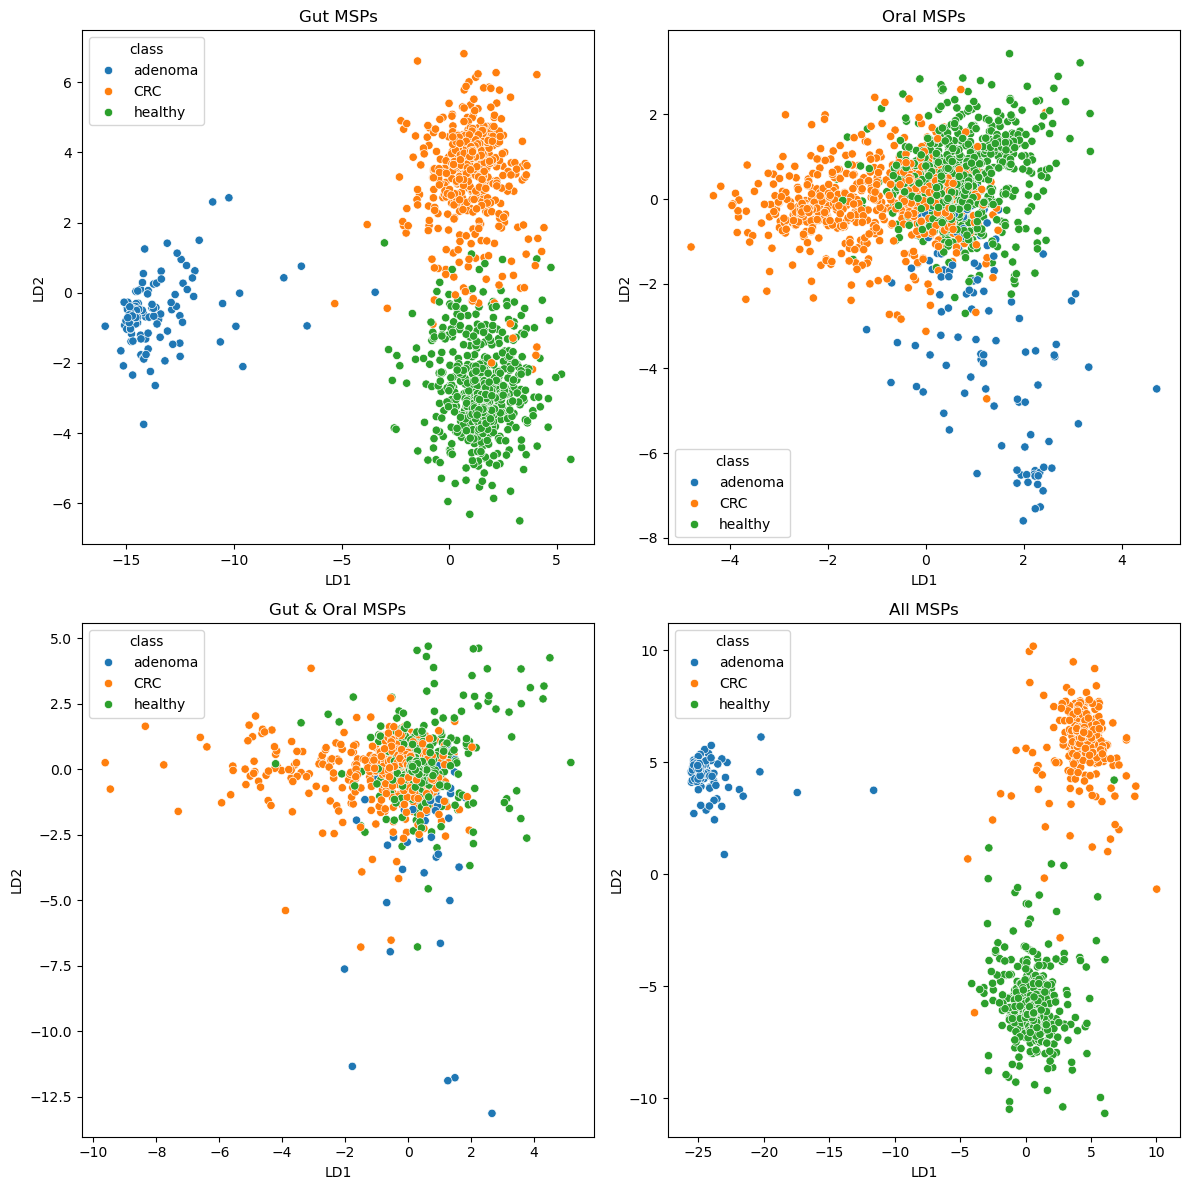

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# top left
sns.scatterplot(data=gut_LDA_df, x='LD1', y='LD2', hue='class', ax=axes[0, 0])
axes[0, 0].set_title('Gut MSPs')

# top right
sns.scatterplot(data=oral_LDA_df, x='LD1', y='LD2', hue='class', ax=axes[0, 1])
axes[0, 1].set_title('Oral MSPs')

# bottom left
sns.scatterplot(data=gut_oral_LDA_df, x='LD1', y='LD2', hue='class', ax=axes[1, 0])
axes[1, 0].set_title('Gut & Oral MSPs')

# bottom right
sns.scatterplot(data=total_LDA_df, x='LD1', y='LD2', hue='class', ax=axes[1, 1])
axes[1, 1].set_title('All MSPs')

plt.tight_layout()
plt.show()

# Model Building

In [ ]:
# splitting the data
total_X_train, total_X_test, total_y_train, total_y_test = train_test_split(total_X, total_y, test_size=0.2, random_state=42)

print(total_X_train.shape)
print(total_X_test.shape)
print(total_y_train.shape)
print(total_y_test.shape)

(1710, 2543)
(428, 2543)
(1710,)
(428,)


In [ ]:
# defining the pipelines
scaler = StandardScaler()
pca = PCA()
ovr_log = OneVsRestClassifier(LogisticRegression())
random_forest = RandomForestClassifier()
mlp = MLPClassifier()

logistic_model = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('ovr_log', ovr_log)
])

random_forest_model = Pipeline([
    ('pca', pca),
    ('random_forest', random_forest)
])

mlp_model = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('mlp', mlp)
])

In [ ]:
# hyperparameter tuning with cross-validation
search_spaces = {
    "LR": {
        "pca__n_components": Integer(25, 300),
        "ovr_log__estimator__C": Real(1e-6, 1e+1, prior='log-uniform'),
        "ovr_log__estimator__penalty": Categorical(['l1', 'l2']),
        "ovr_log__estimator__solver": Categorical(['liblinear', 'saga']),
        "ovr_log__estimator__max_iter": Integer(10000, 20000)
    },
    "RF": {
        "pca__n_components": Integer(25, 300),
        "random_forest__n_estimators": Integer(100, 1000),
        "random_forest__max_depth": Integer(1, 40),
        "random_forest__min_samples_split": Integer(2, 50),
        "random_forest__min_samples_leaf": Integer(1, 10)
    },
    "MLP": {
        "pca__n_components": Integer(25, 300),
        "mlp__hidden_layer_sizes": Categorical([(50,), (100,), (50, 50), (100, 100)]),
        "mlp__activation": Categorical(['relu', 'tanh']),
        "mlp__solver": Categorical(['adam', 'sgd']),
        "mlp__alpha": Real(1e-5, 1e-1, prior='log-uniform'),
        "mlp__learning_rate": Categorical(['constant', 'adaptive']),
        "mlp__max_iter": Integer(10000, 20000)
    }
  }


def hyperparameter_tuning(X_train, y_train):
  best_estimators = {}                                                          # initialize the dictionary that will collect the best models

  for model, name, search_space in zip([logistic_model, random_forest_model, mlp_model],
                                       ["LogisticRegression", "RandomForest", "MultilayerPerceptron"],
                                       [search_spaces["LR"], search_spaces["RF"], search_spaces["MLP"]]):
    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=search_space,
        n_iter=100,
        cv=5,
        scoring="roc_auc_ovr_weighted",
        refit="roc_auc_ovr_weighted",
        return_train_score=True,
        random_state=52,
        verbose=0
    )
    optimizer.fit(X_train, y_train)

    print(f"Best hyperparameters for {name} model: {optimizer.best_params_}")
    print(f"Best score for {name} model: {optimizer.best_score_}")
    print("\n")

    best_estimators[name] = optimizer.best_estimator_                           # this stores the best estimator in an empty dictionary

  return best_estimators

## All MSPs

In [ ]:
best_estimators = hyperparameter_tuning(total_X_train, total_y_train)
best_estimators

Best hyperparameters for LogisticRegression model: OrderedDict({'ovr_log__estimator__C': 0.13527465074742348, 'ovr_log__estimator__max_iter': 20000, 'ovr_log__estimator__penalty': 'l1', 'ovr_log__estimator__solver': 'liblinear', 'pca__n_components': 74})
Best score for LogisticRegression model: 0.7049298726114074




## Gut MSPs

# Evaluating the Model

## All MSPs

In [ ]:
# evaluate the model on test set
def evaluate_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred, average='weighted'))
  print("Recall:", recall_score(y_test, y_pred, average='weighted'))
  print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

for model in [naive_bayes_model, random_forest_model, knn_model]:
  y_scores = evaluate_model(model, total_X_test, total_y_test)

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# ROC-AUC for all 3 models